# Notebook settings
This notebook is a universal frame for training the DistilBERT+Adapted HMCN-F model. It can take in any Parquet dataset with suitable configuration.

In [1]:
### Dataset configuration
# The parquet folder. It should be located inside datasets/.
DATASET_NAME   = 'Arts_Crafts_and_Sewing.parquet'
# The input text column
TEXT_COL_NAME  = 'title'
# Which column to use as labelled classes. It should be a column of lists of strings.
CLASS_COL_NAME = 'category'
# How many hierarchical levels to work on. Note that the dataset must also have at least this many levels for every example.
DEPTH = 2 

### Checkpoint configuration
# Whether to train from scratch or to load a checkpoint
TRAIN_FROM_SCRATCH=False
# Checkpoint iteration to load if not training from scratch
LOAD_ITERATION=0
# Last or best results from that iteration?
LOAD_BEST=True

### System configuration
# Will try to use your NVIDIA GPU if one is available. Set to False to force CPU computation
PREFER_GPU         = True
# If you don't have the huggingface transformers library installed, flip this to True.
# You only need to do this once. Once DistilBERT has been downloaded, it will be cached in your system's default user cache folder.
# Once it is cached, please set this to False to avoid redownloads.
INSTALL_DISTILBERT = False

# Import common libraries
And also set up a few things.

In [2]:
import dask.dataframe as dd
import numpy as np
import torch
from tqdm.notebook import tqdm
import numpy as np
import shutil, sys
from sklearn import metrics
import os

# Set up GPU if available
device = 'cuda' if torch.cuda.is_available() and PREFER_GPU else 'cpu'
print('Using', device)

Using cuda


# Import data

In [3]:
data = dd.read_parquet('../../datasets/{}'.format(DATASET_NAME))
data.head(10)

,category,title,description,brand,feature
index,,,,,
0,"[Sewing, Trim & Embellishments, Appliques & De...",You Son of a Bitch! 1987 Embroidered Patch,The patch features the sweaty masculine handsh...,Honchosfx,[You son of a bitch patch - exclusive to Honch...
1,"[Crafting, Paper & Paper Crafts]",Origami Stars Papers Package 1H (5 packs),"With 5 packs stars folding paper, each pack ar...",,[]
2,"[Crafting, Soap Making]",Pinkie Tm Pinkie new 3D dog animal handmade so...,*2111993*21211991910000TEA2130200,"Kristine Olka,MRobert M. Searns []ACharles A....",[]
3,"[Crafting, Ceramics & Pottery, Clay Molds]",Pinkie Tm Rabbit animal silicone soap mold for...,moldsize:L7.2xW3.7xH4.8cm(L2.83xW1.46xH1.89inc...,pinkie,"[Made in 100% pure silicone,softness and comfo..."
4,"[Crafting, Soap Making, Molds]",Pinkie Tm Female skeleton head soap DIY cold s...,moldsize:L9.5xW7.8xH3.5cm(L3.74xW3.07xH1.38inc...,pinkie,"[Made in 100% pure silicone,softness and comfo..."
5,"[Crafting, Ceramics & Pottery]",Pinkie Tm DIY cactus silicone soap mold Candle...,1.2.3.4.@1/0022/0073/0134/0205/0266/0327/0388/...,,[]
6,"[Crafting, Soap Making, Molds]","Pinkie Tm honeybee bee molds,Handmade silicone...",moldsize:L8.5xW8.5xH3.3cm(L3.35xW3.35xH1.30inc...,pinkie,"[Made in 100% pure silicone,softness and comfo..."
7,"[Crafting, Ceramics & Pottery, Clay Molds]",Pinkie Tm Flower Fairy Soap Mold silicone cand...,moldsize:L7.6xW7.6xH7.6cm(L2.99xW2.99xH2.99inc...,pinkie,"[Made in 100% pure silicone,softness and comfo..."
8,"[Crafting, Soap Making, Molds]",Pinkie Tm angel girl praying Handmade soap sil...,moldsize:L9.5xW7.5xH3.2cm(L3.74xW2.95xH1.25inc...,pinkie,"[Made in 100% pure silicone,softness and comfo..."


# Categorical-encode the classes
Our implementation of HMCN-F uses ordered global-space indices. That is, in the numerical order will be all classes on the first level, THEN those on the second and so on, with each level's first index starting after the previous level's last index.

For categorical encoding to work, the columns themselves must be in Dask's `category` datatype, instead of the default `object` type for non-numerical columns.

In [4]:
def preprocess_classes(data, original_name, depth, verbose=False):
    """
    Build a list of unique class names for each level and create bidirectional mappings.
    """
    cls2idx = []
    idx2cls = []
    for i in range(depth): 
        category_li = data[original_name].apply(
            lambda lst: lst[i], meta=(original_name, 'object')
        ).astype('category').cat.as_known()
        if verbose:
            print(category_li.cat.classes)
        cls2idx.append(dict([
            (category, index) 
            for (index, category) 
            in enumerate(category_li.cat.categories)
        ]))
        idx2cls.append(list(category_li.cat.categories))
    return cls2idx, idx2cls

cls2idx, idx2cls = preprocess_classes(data, CLASS_COL_NAME, DEPTH)    
print(cls2idx)
print('\n')
print(idx2cls)

[{'Beading & Jewelry Making': 0, 'Crafting': 1, 'Fabric Decorating': 2, 'Knitting & Crochet': 3, 'Needlework': 4, 'Organization, Storage & Transport': 5, 'Painting, Drawing & Art Supplies': 6, 'Printmaking': 7, 'Relief & Block Printing Materials': 8, 'Scrapbooking & Stamping': 9, 'Sewing': 10}, {'Adhesive Vinyl': 0, 'Adhesives': 1, 'Albums & Refills': 2, 'Application Tools': 3, 'Art & Poster Tubes': 4, 'Art Paper': 5, 'Art Tool & Sketch Boxes': 6, 'Basket Making': 7, 'Beading Storage': 8, 'Beading Supplies': 9, 'Beads & Bead Assortments': 10, 'Boards & Canvas': 11, 'Brush & Pen Cleaners': 12, 'Candle Making': 13, 'Ceramics & Pottery': 14, 'Charms': 15, 'Chipboard': 16, 'Craft & Sewing Supplies Storage': 17, 'Craft Supplies': 18, 'Crochet Hooks': 19, 'Crochet Kits': 20, 'Crochet Patterns': 21, 'Crochet Thread': 22, 'Cross-Stitch': 23, 'Die-Cutting & Embossing': 24, 'Doll Making': 25, 'Drawing': 26, 'Drawing Paper': 27, 'Drying & Print Racks': 28, 'Easels': 29, 'Embroidery': 30, 'Embroid

Now we can generate indices to use as class labels for training:

In [5]:
def class_to_index(data, original_name, cls2idx, depth):
    data['codes'] = data[original_name].apply(
        lambda lst: [
            cls2idx[i][cat] 
            for (i, cat) 
            in enumerate(lst[:depth])
        ],
        meta=(original_name, 'object')
    ).astype('object')

class_to_index(data, CLASS_COL_NAME, cls2idx, DEPTH)

Lastly, binarise them.

In [6]:
from functools import reduce
# C-HMCNN needs global-space indices. As such we need to offset the level codes.
# We still make use of the local-space code above to increase commonality with other models.
def index_to_binary(data, index_col_name, offsets, sz, verbose=False):
    if verbose:
        print('Using offsets:', offsets)
    
    def generate_binary(codes):
        b = np.zeros(sz, dtype=int)
        indices = np.array(codes, dtype=int) + offsets[:-1]
        if verbose:
            print(codes, offsets, indices)
        b[indices] = 1
        return b.tolist()
    
    data[index_col_name + '_b'] = data[index_col_name].apply(
        lambda lst: generate_binary(lst),
        meta=(index_col_name + '_b', 'object')
    )
    
level_sizes = [*map(lambda lst: len(lst), idx2cls)]
level_offsets = np.array(reduce(lambda acc, elem: acc + [acc[-1] + elem], level_sizes, [0]))
index_to_binary(data, 'codes', level_offsets, sum(level_sizes), verbose=False)

data.head(10)

,category,title,description,brand,feature,codes,codes_b
index,,,,,,,
0,"[Sewing, Trim & Embellishments, Appliques & De...",You Son of a Bitch! 1987 Embroidered Patch,The patch features the sweaty masculine handsh...,Honchosfx,[You son of a bitch patch - exclusive to Honch...,"[10, 100]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
1,"[Crafting, Paper & Paper Crafts]",Origami Stars Papers Package 1H (5 packs),"With 5 packs stars folding paper, each pack ar...",,[],"[1, 64]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[Crafting, Soap Making]",Pinkie Tm Pinkie new 3D dog animal handmade so...,*2111993*21211991910000TEA2130200,"Kristine Olka,MRobert M. Searns []ACharles A....",[],"[1, 90]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[Crafting, Ceramics & Pottery, Clay Molds]",Pinkie Tm Rabbit animal silicone soap mold for...,moldsize:L7.2xW3.7xH4.8cm(L2.83xW1.46xH1.89inc...,pinkie,"[Made in 100% pure silicone,softness and comfo...","[1, 14]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[Crafting, Soap Making, Molds]",Pinkie Tm Female skeleton head soap DIY cold s...,moldsize:L9.5xW7.8xH3.5cm(L3.74xW3.07xH1.38inc...,pinkie,"[Made in 100% pure silicone,softness and comfo...","[1, 90]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,"[Crafting, Ceramics & Pottery]",Pinkie Tm DIY cactus silicone soap mold Candle...,1.2.3.4.@1/0022/0073/0134/0205/0266/0327/0388/...,,[],"[1, 14]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,"[Crafting, Soap Making, Molds]","Pinkie Tm honeybee bee molds,Handmade silicone...",moldsize:L8.5xW8.5xH3.3cm(L3.35xW3.35xH1.30inc...,pinkie,"[Made in 100% pure silicone,softness and comfo...","[1, 90]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,"[Crafting, Ceramics & Pottery, Clay Molds]",Pinkie Tm Flower Fairy Soap Mold silicone cand...,moldsize:L7.6xW7.6xH7.6cm(L2.99xW2.99xH2.99inc...,pinkie,"[Made in 100% pure silicone,softness and comfo...","[1, 14]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,"[Crafting, Soap Making, Molds]",Pinkie Tm angel girl praying Handmade soap sil...,moldsize:L9.5xW7.5xH3.2cm(L3.74xW2.95xH1.25inc...,pinkie,"[Made in 100% pure silicone,softness and comfo...","[1, 90]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


We can try recovering category names from this encoding to see if it is still in the original hierarchical order.

In [7]:
def retrieve_classes(codes, idx2cls):
    return [ idx2cls[i][code] for (i, code) in enumerate(codes) ]

print('Original:', data.loc[3].compute()['category'][0:DEPTH])

print('Retrieved:', retrieve_classes(data['codes'].loc[3].compute().iloc[0], idx2cls))

Original: index
3    [Crafting, Ceramics & Pottery, Clay Molds]
Name: category, dtype: object
Retrieved: ['Crafting', 'Ceramics & Pottery']


# Hierarchy generation
In this model, the hierarchical error penalty is simply $L_H = \lambda \times max(Y_{child} - Y_{parent})$. As such, we need to keep track of each node's parent and vectorise the calculation.

For now I'll be implementing this as simple arrays of category codes (in the global categorical space). We can then use these arrays of codes as vectorised indices to pull out $Y_{parent}$s and have our loss function somewhat vectorised too.

In [8]:
# TODO: Bring the above code into this thing's constructor entirely.
from functools import reduce
class PerLevelHierarchy:
    # level_sizes is a list of (distinct) class counts per hierarchical level.
    #   Its length dictates the maximum hierarchy construction depth.
    #   (that is, our above code)
    # classes is the list of distinct classes, in the order we have assembled.
    def __init__(self, data, cls2idx):
        self.levels = [ len(d.keys()) for d in cls2idx ] # TODO: Rename to level_sizes
        self.classes = reduce(lambda acc, elem: acc + elem, [ list(d.keys()) for d in cls2idx ], [])
        # Where each level starts in a global n-hot category vector
        # Its last element is coincidentally the length, which also allows us
        # to simplify the slicing code by blindly doing [offset[i] : offset[i+1]]
        self.level_offsets = reduce(lambda acc, elem: acc + [acc[len(acc) - 1] + elem], self.levels, [0])
        # Use -1 to indicate 'undiscovered'
        self.parent_of = [-1] * len(self.classes)
        for lst in data['codes']:
            # First-level classes' parent is root, but here we set them to themselves.
            # This effectively zeroes out the hierarchical loss for this level.
            self.parent_of[lst[0]] = lst[0]
            for i in range(1, len(self.levels)):
                child_idx = lst[i] + self.level_offsets[i]
                parent_idx = lst[i-1] + self.level_offsets[i - 1]
                if self.parent_of[child_idx] == -1:
                    self.parent_of[child_idx] = parent_idx

In [9]:
hierarchy = PerLevelHierarchy(data, cls2idx)
hierarchy.parent_of

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 9,
 9,
 9,
 2,
 5,
 6,
 5,
 1,
 5,
 0,
 0,
 6,
 6,
 1,
 1,
 0,
 9,
 5,
 1,
 3,
 3,
 3,
 3,
 4,
 9,
 1,
 6,
 6,
 5,
 6,
 4,
 10,
 0,
 7,
 2,
 2,
 4,
 2,
 5,
 1,
 0,
 7,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 1,
 0,
 1,
 3,
 4,
 4,
 5,
 6,
 1,
 9,
 1,
 1,
 0,
 5,
 8,
 7,
 7,
 4,
 0,
 10,
 7,
 10,
 9,
 9,
 1,
 7,
 1,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 1,
 1,
 9,
 9,
 10,
 5,
 5,
 1,
 4,
 10,
 10,
 0,
 1,
 1]

## Checkpoints

In [10]:
def load_checkpoint(checkpoint_fpath, model):
    encoder, classifier = model
    checkpoint = torch.load(checkpoint_fpath)
    classifier.load_state_dict(checkpoint['state_dict'])
    return (encoder, classifier)

def save_checkpoint(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)

## Metrics
We define hierarchical accuracy as simply the averaged accuracy over each level. Same for precision. With HMCN-F, we use the final output $P_F$.
In addition to those, at the end of the testing phase we'll also compute the average area under the precision-recall curve (AU(PRC)).

In [11]:
def get_metrics(outputs, targets, level_sizes, print_metrics=True):
    offsets = [0] + level_sizes
    level_codes = [ 
        np.argmax(outputs[:, offsets[level] : offsets[level + 1]], axis=1) + offsets[level] 
        for level in range(len(level_sizes))
    ]
    
    target_codes = np.array([ np.nonzero(lst)[0] for lst in targets ], dtype=int)
    
    accuracies = [ metrics.accuracy_score(level_codes[level], target_codes[:, level]) for level in range(len(level_sizes)) ]
    precisions = [ metrics.precision_score(level_codes[level], target_codes[:, level], average='weighted') for level in range(len(level_sizes)) ]
    
    global_accuracy = sum(accuracies)/len(accuracies)
    global_precision = sum(precisions)/len(precisions)
    
    if print_metrics:
        for i in range(len(level_sizes)):
            print('Level {}:'.format(i))
            print("Accuracy:", accuracies[i])
            # Model Precision: what percentage of positive tuples are labeled as such?
            print("Precision:", precisions[i],'\n')
        print('Path average:')
        print('Accuracy:', global_accuracy)
        print('Precision:', global_precision)
    
    return np.array([accuracies[-1], precisions[-1], global_accuracy, global_precision])

# Data and model preparation

## Installing DistilBERT
Alternative to full-fat BERT, roughly matching its performance while being faster.

In [12]:
if not INSTALL_DISTILBERT:
    os.environ['TRANSFORMERS_OFFLINE'] = '1'
else:
    !pip install transformers
    
import transformers as ppb
tokenizer = ppb.DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
base_encoder = ppb.DistilBertModel.from_pretrained('distilbert-base-uncased')
base_encoder_state = base_encoder.state_dict()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Define our dataset adapter class
This wraps around our data and provides a PyTorch-compatible interface.

In [13]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self, df, hierarchy, tokenizer, max_len, text_col_name = TEXT_COL_NAME):
    self.tokenizer = tokenizer
    self.text = df[text_col_name]
    # Level sizes
    self.levels = hierarchy.levels
    self.labels = df.codes_b
    self.level_offsets = hierarchy.level_offsets
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, index):
    text = str(self.text.iloc[index])
    text = " ".join(text.split())
    inputs = self.tokenizer(
      text,
      None, # No text_pair
      add_special_tokens=True, # CLS, SEP
      max_length=self.max_len, # For us it's a hyperparam. See next cells.
      padding='max_length',
      truncation=True
      # BERT tokenisers return attention masks by default
    )

    labels = torch.tensor(self.labels.loc[index], dtype=torch.long)

    result = {
      'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
      'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
      'labels': labels,
    }

    return result

Regarding that `max_len` hyperparameter, let's see the text lengths' distribution:

/usr/lib/python3.9/site-packages/dask/dataframe/core.py:3718: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('title', 'int64'))

  warnings.warn(meta_warning(meta))


<AxesSubplot:>

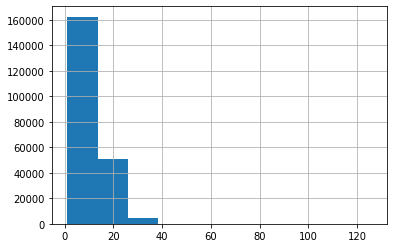

In [14]:
data[TEXT_COL_NAME].apply(lambda s: len(s.split())).compute().hist()

We prefer `max_len` to be a power of two that covers most of the strings. Here it seems 64 will do.

In [15]:
###
### TUNING HYPERPARAMETERS?
### Simply adjust here then run this cell and those below it. No need to run those above.
###

folder_name = 'checkpoints-' + DATASET_NAME
!mkdir $folder_name
CHECKPOINT_IDX = len(os.listdir(folder_name)) // 2
CHECKPOINT_PATH = './{}/{}_current.pt'.format(folder_name, CHECKPOINT_IDX)
BEST_CHECKPOINT_PATH = './{}/{}_best.pt'.format(folder_name, CHECKPOINT_IDX)

config = {
    'cls_lr': 1e-03,
    'lambda_h': 0.7,
    'epochs': 5,
    'dropout': 0.25,
    'global_hidden_sizes': [384] * len(hierarchy.levels),
    'local_hidden_sizes': [384] * len(hierarchy.levels),
    'global_weight': 0.5,
    'hidden_nonlinear': 'relu'
}

### Don't change these if you need to compare with published results
MAX_LEN = 64
TRAIN_MINIBATCH_SIZE = 64
VAL_TEST_MINIBATCH_SIZE = 64
TRAIN_SET_RATIO = 0.8
VAL_SET_RATIO = 0.1
# The rest is test set
RANDOM_SEED = 123
# Flip to False for faster hyperparameter tuning. If False, only 5% of the full dataset is used. 
FULL_SET = True

mkdir: cannot create directory ‘checkpoints-Arts_Crafts_and_Sewing.parquet’: File exists


CV-split our dataset:

In [16]:
small_data = None
if not FULL_SET:
    small_data = data.sample(frac = 0.05, random_state=RANDOM_SEED)

train_set = None
test_set = None

COLUMNS = [TEXT_COL_NAME, 'codes_b']

filtered = None
if FULL_SET:
    filtered = data[COLUMNS].compute()
else:
    filtered = small_data[COLUMNS].compute()

train_set = filtered.sample(frac = TRAIN_SET_RATIO, random_state=RANDOM_SEED)
val_test_set = filtered.drop(train_set.index)

val_set = val_test_set.sample(frac = VAL_SET_RATIO / (1-TRAIN_SET_RATIO), random_state=RANDOM_SEED)
test_set = val_test_set.drop(val_set.index)

train_set = train_set.reset_index(drop=True)
val_set = val_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

(174176, 2)
(21772, 2)
(21772, 2)


We can now wrap them in our Datasets, and then into PyTorch's DataLoaders.

In [17]:
train_set_wrapped = CustomDataset(train_set, hierarchy, tokenizer, MAX_LEN)
val_set_wrapped = CustomDataset(val_set, hierarchy, tokenizer, MAX_LEN)
test_set_wrapped = CustomDataset(test_set, hierarchy, tokenizer, MAX_LEN)

train_loader = torch.utils.data.DataLoader(dataset=train_set_wrapped, batch_size=TRAIN_MINIBATCH_SIZE, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(dataset=val_set_wrapped, batch_size=VAL_TEST_MINIBATCH_SIZE, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=test_set_wrapped, batch_size=VAL_TEST_MINIBATCH_SIZE, shuffle=True, num_workers=0)

Test-run:

In [18]:
test_batch = next(iter(test_loader))
test_batch

{'ids': tensor([[  101,  1031,  1018,  ...,     0,     0,     0],
         [  101,  5394,  2840,  ...,     0,     0,     0],
         [  101,  3782,  1011,  ...,     0,     0,     0],
         ...,
         [  101, 13675, 28852,  ...,     0,     0,     0],
         [  101, 13528, 11554,  ...,     0,     0,     0],
         [  101,  2227,  3064,  ...,     0,     0,     0]]),
 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0]])}

## Prepare the model itself
Here we use DistilBERT as the encoding layers, followed by our implementation of HMCN-F.

### HMCN-F
HMCN-F is specifically designed for maximizing the learn-
ing capacity regarding the hierarchical structure of the la-
beled data.

In this model, information flows in two ways:
i) the main flow, which begins with the input layer and tra-
verses all fully-connected (FC) layers until it reaches the
global output; and ii) the local flows, which also begin in the
input layer and pass by their respective global FC layers but
also through specific local FC layers, finally ending at the
corresponding local output. For generating the final prediction, all local outputs are then concatenated and pooled with
the global output for a consensual prediction.

Code2paper notation mapping:
- `feature_size` = $|D|$
- `global_hidden_sizes` = list of $|A^i_G|$ for i in $[1, |H|]$
- `local_hidden_sizes` = list of $|A^i_L|$ for i in $[1, |H|]$
- hierarchy:
  - `len(hierarchy.levels)` = $|H|$
  - `len(hierarchy.classes)` = $|C|$
- `global_weight` = $\beta$

**One significant difference between our version and the one in the paper** is that we replace batch normalisation with layer normalisation, which doesn't wreack havoc on NLP tasks like ours.

The FC (linear) layers comprise 384 ReLU
neurons, followed by a batch normalization, residual connections, and dropout of 60%. Dropout is important given
that these models could easily overfit the small training sets.

In [19]:
from tqdm.notebook import tqdm

class HMCNF(torch.nn.Module):
  def __init__(
      self, 
      input_dim, 
      hierarchy,
      config,
      ):
    super(HMCNF, self).__init__()

    # Back up some parameters for use in forward()
    self.depth = len(hierarchy.levels)
    self.global_weight = config['global_weight']

    # Construct global layers (main flow)
    global_layers = []
    global_layer_norms = []
    for i in range(len(hierarchy.levels)):
      if i == 0:
        global_layers.append(
            torch.nn.Linear(input_dim, config['global_hidden_sizes'][0]))
      else:
        global_layers.append(
            torch.nn.Linear(config['global_hidden_sizes'][i-1] + input_dim, config['global_hidden_sizes'][i]))
      global_layer_norms.append(torch.nn.LayerNorm(config['global_hidden_sizes'][i]))
    self.global_layers = torch.nn.ModuleList(global_layers)
    self.global_layer_norms = torch.nn.ModuleList(global_layer_norms)
    # Global prediction layer
    self.global_prediction_layer = torch.nn.Linear(
        config['global_hidden_sizes'][-1] + input_dim, 
        len(hierarchy.classes)
        )
    
    # Construct local branches (local flow).
    # Each local branch has two linear layers: a transition layer and a local
    # classification layer 
    transition_layers = []
    local_layer_norms = []
    local_layers = []
    
    for i in range(len(hierarchy.levels)):
      transition_layers.append(
          torch.nn.Linear(config['global_hidden_sizes'][i], config['local_hidden_sizes'][i]),
      )
      local_layer_norms.append(
          torch.nn.LayerNorm(config['local_hidden_sizes'][i])
      )
      local_layers.append(
          torch.nn.Linear(config['local_hidden_sizes'][i], hierarchy.levels[i])
      )
    self.local_layer_norms = torch.nn.ModuleList(local_layer_norms)
    self.transition_layers = torch.nn.ModuleList(transition_layers)
    self.local_layers = torch.nn.ModuleList(local_layers)
    
    # Activation functions
    self.hidden_nonlinear = torch.nn.ReLU() if config['hidden_nonlinear'] == 'relu' else torch.nn.Tanh()
    self.output_nonlinear = torch.nn.Sigmoid()

    # Dropout
    self.dropout = torch.nn.Dropout(p=config['dropout'])

  def forward(self, x):
    # We have |D| hidden layers plus one global prediction layer
    local_outputs = []
    output = x # Would be global path output until the last step
    for i in range(len(self.global_layers)):
      # Global path
      if i == 0:
        # Don't concatenate x into the first layer's input
        output = self.hidden_nonlinear(
            self.global_layer_norms[i](
                self.global_layers[i](output)
                )
            )
      else:
        output = self.hidden_nonlinear(self.global_layer_norms[i](
                self.global_layers[i](torch.cat([output, x], dim=1))
              )
            )

      # Local path. Note the dropout between the transition ReLU layer and the local layer.
      local_output = self.dropout(
          self.hidden_nonlinear(
              self.local_layer_norms[i](self.transition_layers[i](output))
              )
            )
      local_output = self.output_nonlinear(self.local_layers[i](local_output))
      local_outputs.append(local_output)

      # Dropout main flow for next layer
      # TODO: investigate introducing layernorm here
      output = self.dropout(output)

    global_outputs = self.output_nonlinear(
      self.global_prediction_layer(torch.cat([output, x], dim=1))
      )
    local_outputs_concat = torch.cat(local_outputs, dim=1)
    output = self.global_weight * global_outputs + (1 - self.global_weight) * local_outputs_concat
    return output, local_outputs

### Entire model

In [20]:
encoder = base_encoder
encoder.load_state_dict(base_encoder_state)
encoder.to(device)

depth = len(hierarchy.levels)
classifier = HMCNF(
  768, # DistilBERT outputs 768 values.
  hierarchy,
  config
)

classifier.to(device)

HMCNF(
  (global_layers): ModuleList(
    (0): Linear(in_features=768, out_features=384, bias=True)
    (1): Linear(in_features=1152, out_features=384, bias=True)
  )
  (global_layer_norms): ModuleList(
    (0): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  )
  (global_prediction_layer): Linear(in_features=1152, out_features=115, bias=True)
  (local_layer_norms): ModuleList(
    (0): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  )
  (transition_layers): ModuleList(
    (0): Linear(in_features=384, out_features=384, bias=True)
    (1): Linear(in_features=384, out_features=384, bias=True)
  )
  (local_layers): ModuleList(
    (0): Linear(in_features=384, out_features=11, bias=True)
    (1): Linear(in_features=384, out_features=104, bias=True)
  )
  (hidden_nonlinear): ReLU()
  (output_nonlinear): Sigmoid()
  (dropout): Dropout(p=0.25, inplace=F

# Training time

In [21]:
from tqdm.notebook import tqdm

def train_model(config, train_loader, val_loader, model, hierarchy, checkpoint_path, best_checkpoint_path):
  encoder, classifier = model

  # TODO: Somehow do this on GPU
  parent_of = torch.LongTensor(hierarchy.parent_of)

  # Store validation metrics after each epoch
  val_metrics = np.empty((4, 0), dtype=float)

  # Keep min validation (test set) loss so we can separately back up our best-yet model
  val_loss_min = np.Inf

  criterion = torch.nn.BCELoss()
  optimizer = torch.optim.Adam(params=classifier.parameters(), lr=config['cls_lr'])

  # Hierarchical loss gain
  lambda_h = config['lambda_h']
  for epoch in range(1, config['epochs'] + 1):
    train_loss = 0
    val_loss = 0
    # Put model into training mode. Note that this call DOES NOT train it yet.
    classifier.train()
    print('Epoch {}: Training'.format(epoch))
    for batch_idx, data in enumerate(tqdm(train_loader, total=train_minibatch_count)):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      targets = data['labels'].to(device, dtype = torch.float)

      features = encoder(ids, mask)[0][:,0,:]
      output, local_outputs = classifier(features)

      optimizer.zero_grad()

      # We have three loss functions: (g)lobal, (l)ocal, and (h)ierarchical.
      loss_g = criterion(output, targets)
      loss_l = sum([ criterion(
            local_outputs[level],
            targets[:, hierarchy.level_offsets[level] : hierarchy.level_offsets[level + 1]]
            ) for level in range(len(hierarchy.levels))])
      output_cpu = output.cpu().detach()
      loss_h = torch.sum(lambda_h * torch.clamp(torch.FloatTensor(
        output_cpu - 
        output_cpu.index_select(1, parent_of)
      ), min=0) ** 2)
      loss = loss_g + loss_l + loss_h

      # PyTorch defaults to accumulating gradients, but we don't need that here
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss = train_loss + (loss.item() - train_loss) / (batch_idx + 1)

    print('Epoch {}: Testing'.format(epoch))
    
    
    # Switch to evaluation (prediction) mode. Again, this doesn't evaluate anything.
    classifier.eval()

    val_targets = np.empty((0, len(hierarchy.classes)), dtype=bool)
    val_outputs = np.empty((0, len(hierarchy.classes)), dtype=float)
    local_val_outputs = np.empty((0, len(hierarchy.classes)), dtype=float)

    # We're only testing here, so don't run the backward direction (no_grad).
    with torch.no_grad():
      total_loss_g = 0
      total_loss_l = 0
      total_loss_h = 0
      for batch_idx, data in tqdm(enumerate(val_loader), total=val_minibatch_count):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['labels'].to(device, dtype = torch.float)

        features = encoder(ids, mask)[0][:,0,:]
        output, local_outputs = classifier(features)

        loss_g = criterion(output, targets)
        loss_l = sum([ criterion(
              local_outputs[level],
              targets[:, hierarchy.level_offsets[level] : hierarchy.level_offsets[level + 1]]
              ) for level in range(len(hierarchy.levels))])
        output_cpu = output.cpu().detach()
        loss_h = torch.sum(lambda_h * torch.clamp(torch.FloatTensor(
          output_cpu - 
          output_cpu.index_select(1, parent_of)
        ), min=0) ** 2)
        loss = loss_g + loss_l + loss_h

        total_loss_g += loss_g
        total_loss_l += loss_l
        total_loss_h += loss_h

        val_loss = val_loss + (loss.item() - val_loss) / (batch_idx + 1)

        val_targets = np.concatenate([val_targets, targets.cpu().detach().numpy()])
        val_outputs = np.concatenate([val_outputs, output_cpu.numpy()])
        # Concatenate local test outputs
        local_val_outputs_concat = np.concatenate([*map(lambda t: t.cpu().detach().numpy(), local_outputs)], axis=1)
        local_val_outputs = np.concatenate([local_val_outputs, local_val_outputs_concat])

      # calculate average losses
      #print('before cal avg train loss', train_loss)
      print('Average minibatch global loss:', total_loss_g / val_minibatch_count)
      print('Average minibatch local loss:', total_loss_l / val_minibatch_count)
      print('Average minibatch hierarchical loss:', total_loss_h / val_minibatch_count)
    
      val_metrics = np.concatenate(
          [
            val_metrics, 
            np.expand_dims(
              get_metrics(val_outputs, val_targets, hierarchy.levels), 
              axis=1
            )
          ],
          axis=1
      )
      train_loss = train_loss/train_minibatch_count
      val_loss = val_loss/val_minibatch_count
      # Print training/validation statistics 
      print('Avgerage training loss: {:.6f}\nAverage validation loss: {:.6f}'.format( 
            train_loss,
            val_loss
            ))

      # create checkpoint variable and add important data
      checkpoint = {
            'state_dict': classifier.state_dict(),
            'optimizer': optimizer.state_dict()
      }

      best_yet = False
      if val_loss <= val_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min,val_loss))
        # save checkpoint as best model
        best_yet = True
        val_loss_min = val_loss
      save_checkpoint(checkpoint, best_yet, checkpoint_path, best_checkpoint_path)
    print('Epoch {}: Done\n'.format(epoch))
  return (encoder, classifier), val_metrics

# Alternative: just load from disk
def run_model(model, loader, hierarchy, minibatch_count = None):
  encoder, classifier = model
  # Switch to evaluation (prediction) mode. Again, this doesn't evaluate anything.
  classifier.eval()

  all_targets = np.empty((0, len(hierarchy.classes)), dtype=bool)
  all_outputs = np.empty((0, len(hierarchy.classes)), dtype=float)
  all_local_outputs = np.empty((0, len(hierarchy.classes)), dtype=float)

  # We're only testing here, so don't run the backward direction (no_grad).
  with torch.no_grad():
    for batch_idx, data in enumerate(tqdm(loader, total=minibatch_count)):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      targets = data['labels']

      features = encoder(ids, mask)[0][:,0,:]
      output, local_outputs = classifier(features)

      all_targets = np.concatenate([all_targets, targets.numpy()])
      all_outputs = np.concatenate([all_outputs, output.cpu().detach().numpy()])
      # Concatenate local test outputs
      local_outputs_concat = np.concatenate([*map(lambda t: t.cpu().detach().numpy(), local_outputs)], axis=1)
      all_local_outputs = np.concatenate([all_local_outputs, local_outputs_concat])
  return {
      'targets': all_targets,
      'outputs': all_outputs,
      'local_outputs': all_local_outputs,
  }

In [22]:
import matplotlib.pyplot as plt

trained_model = None
if TRAIN_FROM_SCRATCH:
    trained_model, val_metrics = train_model(
        config,
        train_loader, 
        val_loader, 
        (encoder, classifier),
        hierarchy,
        CHECKPOINT_PATH,
        BEST_CHECKPOINT_PATH,
    )
    x = np.arange(config['epochs'])
    fig, ax = plt.subplots()  # Create a figure and an axes.
    ax.plot(x, val_metrics[0], label='leaf accuracy')
    ax.plot(x, val_metrics[1], label='leaf precision')
    ax.plot(x, val_metrics[2], label='average global accuracy')
    ax.plot(x, val_metrics[3], label='average global precision')
    ax.set_xlabel('epoch')  # Add an x-label to the axes.
    ax.set_ylabel('score')  # Add a y-label to the axes.
    ax.set_title("Accuracy/precision over epochs")  # Add a title to the axes.
    ax.legend()  # Add a legend.
    fig.show()
else:
    load_path = '{}/{}_{}.pt'.format(folder_name, LOAD_ITERATION, 'best' if LOAD_BEST else 'current')
    trained_model = load_checkpoint(load_path, (encoder, classifier))

RuntimeError: Error(s) in loading state_dict for HMCNF:
	size mismatch for global_prediction_layer.weight: copying a param with shape torch.Size([114, 1152]) from checkpoint, the shape in current model is torch.Size([115, 1152]).
	size mismatch for global_prediction_layer.bias: copying a param with shape torch.Size([114]) from checkpoint, the shape in current model is torch.Size([115]).
	size mismatch for local_layers.1.weight: copying a param with shape torch.Size([103, 384]) from checkpoint, the shape in current model is torch.Size([104, 384]).
	size mismatch for local_layers.1.bias: copying a param with shape torch.Size([103]) from checkpoint, the shape in current model is torch.Size([104]).

In [ ]:
test_set = CustomDataset(data_test, tokenizer, MAX_LEN)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=VAL_TEST_MINIBATCH_SIZE)
test_result = run_model(trained_model, test_loader, hierarchy, test_minibatch_count)

# Evaluation
We'll mainly use the leaf prediction in real-world applications to ensure 100% hierarchy matches. However, we'll still test with the global encoding just to see what we are getting.

In [ ]:
get_metrics(test_result['outputs'], test_result['targets'], level_sizes)

# Rectified leaf AU(PRC) due to an sklearn bug.
# We add one artificial example that belongs to all classes at once and a corresponding prediction
# full of true positives. This way each class has at least one true positive, even if the test set
# does not contain enough examples to cover all classes.
rectified_outputs = np.concatenate([test_result['outputs'][:, level_offsets[-2]:], np.ones((1, level_sizes[-1]))], axis=0)
rectified_targets = np.concatenate([test_result['targets'][:, level_offsets[-2]:], np.ones((1, level_sizes[-1]), dtype=bool)], axis=0)

print('\n')
print('Rectified leaf-level AU(PRC) score:', metrics.average_precision_score(rectified_targets, rectified_outputs))

## Hierarchical predictions
Let's have another visual match-up, but this time for the entire hierarchy.

In [ ]:
path_codes = np.concatenate([
    np.expand_dims(
        np.argmax(test_result['outputs'][:, hierarchy.level_offsets[level] : hierarchy.level_offsets[level + 1]], axis=1),
        axis=1
    ) for level in range(len(hierarchy.levels))],
    axis=1
)

target_codes = np.array([ np.nonzero(lst)[0] - hierarchy.level_offsets[:-1] for lst in test_result['targets'] ], dtype=int)
print(path_codes.shape)
print(target_codes.shape)

In [ ]:
predicted_classes = [retrieve_classes(row, idx2cls) for row in tqdm(path_codes)]
actual_classes = [retrieve_classes(row, idx2cls) for row in tqdm(target_codes)]
import pandas as pd
comp_df = pd.DataFrame({ 'Hierarchical prediction': predicted_classes, 'Actual hierarchy': actual_classes})
comp_df

# Past results
- `_1`: Equal to `_9` in Walmart_Marketing. However, we now use 10% validation 10% test instead of 20% test.

```
```